# Modifying observational targets to account for structural uncertainty

## Reading in data

Import modules

In [1]:
import numpy as np
from scipy.io import netcdf as nc
import matplotlib.pyplot as plt

List of input variables

In [2]:
in_vars = ['medlynslope','dleaf','kmax','fff','dint','baseflow_scalar']
npar = len(in_vars)

Read input PPE parameter scalings

In [3]:
inputdata = np.load("lhc_100.npy", allow_pickle=True)
#inputdata.shape

Select output variables

In [4]:
var = ["GPP", "LHF"]
nvar = len(var)

Read PPE first 3 modes from SVD

In [5]:
PPE_modes = [np.load("outputdata/outputdata_"+v+"_SVD_3modes.npy") for v in var]
# temporarily drop 3rd mode
#PPE_modes[0] = PPE_modes[0][:,:2]
#PPE_modes[1] = PPE_modes[1][:,:2]
nmodes = PPE_modes[0].shape[1]
#PPE_modes[1][:,0].shape
PPE_modes_mean = np.mean(PPE_modes, axis=1)
#PPE_modes_mean.shape

Set % variance explained (for weighted loss function)

In [6]:
# variance recorded in NN develop and test spreadsheet, taken from SVD.py
var_modes = [[0.8341,0.1349,0.0119],[0.7701996,0.12915632,0.05642754]]
#var_modes[0]

Read obs first 3 modes from SVD, and sd across all years of obs

In [7]:
obs_modes = [np.load("obs/obs_"+v+"_SVD_3modes.npy") for v in var]
#print(obs_modes)
obs_sd = [np.load("obs/obs_"+v+"_SVD_3modes_allyrs_sd.npy") for v in var]
#obs_sd

Read default model first 3 modes from SVD

In [8]:
default_modes = [np.load("outputdata/modeldefault_"+v+"_SVD_3modes.npy") for v in var]
#default_modes

Calculate "meta-obs" combining obs and model default

In [9]:
#ff = 10 # IMPORTANT scaling factor - need to do sensitivity tests
ff = 100
mobs_modes = [default_modes[i] + (obs_modes[i])/ff for i,v in enumerate(var)]
#mobs_modes

Calculate normalized error using PPE results (i.e, what is the optimization baseline goal?)

In [10]:
PPE_err = np.sum([np.sum(var_modes[i]*((PPE_modes[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)], axis=0) # meta-obs, mode wgt
#PPE_err = np.sum([np.sum(var_modes[i]*((PPE_modes[i]-obs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)], axis=0) # mode wgt only
#PPE_err = np.sum([np.sum(((PPE_modes[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)], axis=0) # meta-obs only
PPE_opt = np.argmin(PPE_err)
print(PPE_opt) # ensemble member
print(PPE_err[PPE_opt]) # minimum value for PPE_err
print(inputdata[PPE_opt,:]) # parameter scalers for optimal PPE run
#plt.plot(PPE_err);
#plt.hist(PPE_err);

26
3571.0396365060465
[0.6413278274274661 0.5025909873643246 0.48701789515362526
 0.6442804436490553 0.6922904732585837 0.3997159562023937]


## Plot distribution with obs and default

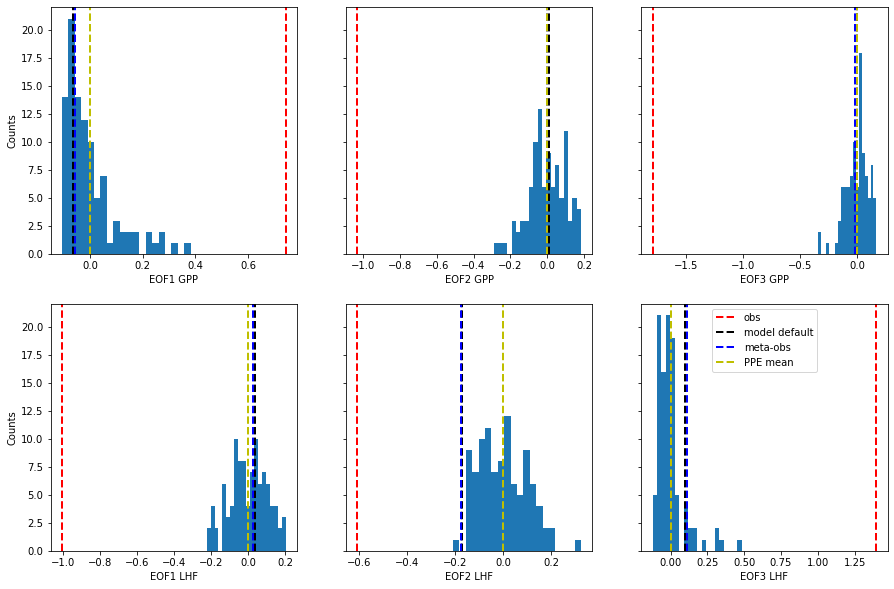

In [11]:
fig, axs = plt.subplots(nvar,nmodes, figsize=(15, 10), sharey=True)
axs = axs.ravel()
for j in range(nvar):
    for i in range(nmodes):
        # indexing is a little hacky
        axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=20)
        axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
        axs[i+nmodes*j].axvline(x=obs_modes[j][:,i], color='r', linestyle='dashed', linewidth=2, label="obs")
        axs[i+nmodes*j].axvline(x=default_modes[j][:,i], color='k', linestyle='dashed', linewidth=2, label="model default")
        axs[i+nmodes*j].axvline(x=mobs_modes[j][:,i], color='b', linestyle='dashed', linewidth=2, label="meta-obs")
        axs[i+nmodes*j].axvline(x=PPE_modes_mean[j,i], color='y', linestyle='dashed', linewidth=2, label="PPE mean")
        if i == 0:
            axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();
#plt.savefig("dist_outputdata_GPP_LHF_SVD_withobs_anddefault_andmetaobs.pdf")

## Single point optimization

More modules

In [12]:
from scipy.optimize import shgo, dual_annealing, differential_evolution
import keras.backend as K
from keras.models import load_model

Using TensorFlow backend.
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/glade/work/kd

Define error metric for trained NN

In [13]:
def mean_sq_err(y_true,y_pred):
    return K.mean((y_true-y_pred)**2)

Load previously trained model

In [14]:
NN_models = [load_model("emulators/NN_"+v+"_finalize_multi-dim.h5", 
    custom_objects={'mean_sq_err' :mean_sq_err}) for v in var]

W1014 16:40:32.141066 140478212212480 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1014 16:40:32.155598 140478212212480 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1014 16:40:32.207437 140478212212480 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1014 16:40:32.208187 140478212212480 deprecation_wrapper.py:119] From /glade/work/kdagon/miniconda/envs/ML/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:200: The name tf.ConfigProto 

Set weighting factor for likelihood function -- no longer needed?

In [15]:
#B = 1.49

Testing out predictions

In [16]:
# Try generating LHC initial values
#from pyDOE import *
#lhd = lhs(npar,samples=1) # default sampling criterion = random
#x0 = lhd[0,:]
#x0t = x0.reshape(1,-1)
#test_preds = [NN_models[i].predict(x0t) for i,v in enumerate(var)]
#test_preds

In [17]:
#test_terms = [np.sum(var_modes[i]*((test_preds[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
#print(test_terms)
#np.sum(test_terms)

Define likelihood function using emulator predictions

In [18]:
def normerr(x):
    xt = x.reshape(1,-1) # needed for input to model.predict
    NN_preds = [NN_models[i].predict(xt) for i,v in enumerate(var)]
    terms = [np.sum(var_modes[i]*((NN_preds[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # meta-obs, mode wgt
    #terms = [np.sum(var_modes[i]*((NN_preds[i]-obs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # mode wgt only
    #terms = [np.sum(((NN_preds[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # meta-obs only
    # Weighted multiple objectives
    #L = terms[0] + B*terms[1]
    # Unweighted multiple objectives (generally doesn't change SHGO result)
    L = np.sum(terms)
    return L

SHGO global optimization

In [19]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
res = shgo(normerr, bounds)
print(res)
# Do the initial conditions for SHGO matter? Is it getting stuck? Not iterating very much...

     fun: 4736.895012922347
    funl: array([4736.89501292])
 message: 'Optimization terminated successfully.'
    nfev: 73
     nit: 2
   nlfev: 8
   nlhev: 0
   nljev: 1
 success: True
       x: array([1., 1., 1., 1., 1., 1.])
      xl: array([[1., 1., 1., 1., 1., 1.]])


Modified SHGO options

In [20]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
res = shgo(normerr, bounds, iters=3, sampling_method='sobol') # result generally does not change when iters goes from 1-5
print(res)

     fun: 3668.08274811455
    funl: array([3668.08274811])
 message: 'Optimization terminated successfully.'
    nfev: 308
     nit: 3
   nlfev: 8
   nlhev: 0
   nljev: 1
 success: True
       x: array([0.72265625, 0.65234375, 0.96484375, 0.60546875, 0.89453125,
       0.62890625])
      xl: array([[0.72265625, 0.65234375, 0.96484375, 0.60546875, 0.89453125,
        0.62890625]])


Dual Annealing global optimization

In [21]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
from pyDOE import *
lhd = lhs(npar,samples=1) # default sampling criterion = random
x0 = lhd[0,:]
#print(x0)
res = dual_annealing(normerr, bounds=bounds, x0=x0)
#res = dual_annealing(normerr, bounds, maxiter=10000, x0=x0)
print(res)

     fun: 1099.827406827554
 message: ['Maximum number of iteration reached']
    nfev: 19407
    nhev: 0
     nit: 1000
    njev: 0
  status: 0
 success: True
       x: array([0.7022268 , 0.51690742, 0.99955438, 0.15724187, 0.97321247,
       0.21201266])


Differential Evolution global optimization -- generally this method is best at finding minimum error

In [22]:
bounds = [(0,1), (0,1), (0,1), (0,1), (0,1), (0,1)]
#res = differential_evolution(normerr, bounds, init='latinhypercube', disp=True) # with display progress
res = differential_evolution(normerr, bounds, init='latinhypercube')
#res = differential_evolution(normerr, bounds, init='random')
print(res)

     fun: 885.80039579343
     jac: array([     0.        ,      0.        , -21424.40907846,      0.        ,
            0.        ,      0.        ])
 message: 'Optimization terminated successfully.'
    nfev: 6787
     nit: 72
 success: True
       x: array([5.78583455e-01, 5.60850873e-02, 9.99311172e-01, 1.32759683e-01,
       8.79295888e-01, 1.24649344e-04])


Given single point results, what are the optimized predictions and terms of the normalized error?

In [23]:
opt_preds = [NN_models[i].predict(res.x.reshape(1,-1)) for i,v in enumerate(var)]
#opt_preds

Does one term (GPP or LHF) dominate the total error?

In [24]:
#terms_preds = [np.sum(var_modes[i]*((opt_preds[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)]
#terms_preds

## Plot distribution with optimized predictions

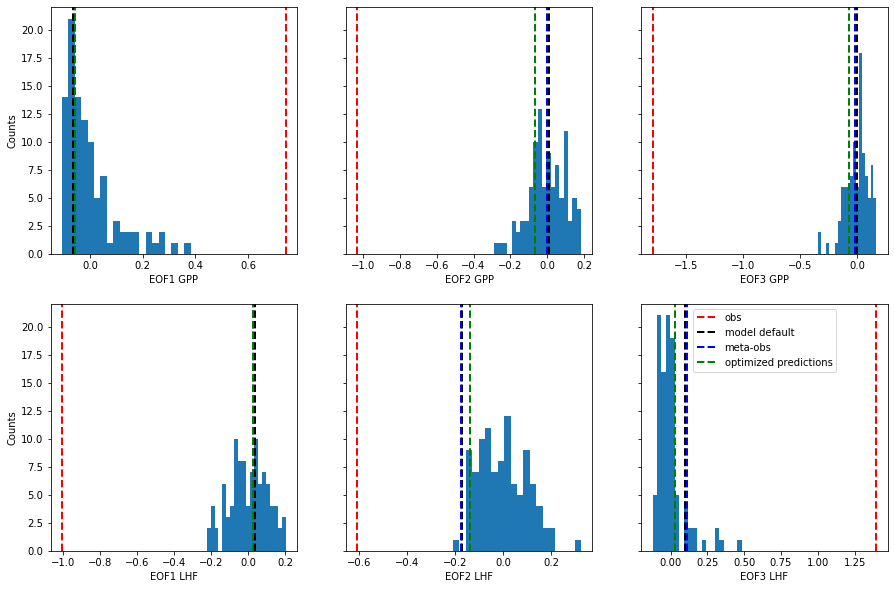

In [25]:
fig, axs = plt.subplots(nvar,nmodes, figsize=(15, 10), sharey=True)
axs = axs.ravel()
for j in range(nvar):
    for i in range(nmodes):
        # indexing is a little hacky
        axs[i+nmodes*j].hist(PPE_modes[j][:,i], bins=20)
        axs[i+nmodes*j].set_xlabel("EOF"+str(i+1)+" "+var[j])
        axs[i+nmodes*j].axvline(x=obs_modes[j][:,i], color='r', linestyle='dashed', linewidth=2, label="obs")
        axs[i+nmodes*j].axvline(x=default_modes[j][:,i], color='k', linestyle='dashed', linewidth=2, label="model default")
        axs[i+nmodes*j].axvline(x=mobs_modes[j][:,i], color='b', linestyle='dashed', linewidth=2, label="meta-obs")
        axs[i+nmodes*j].axvline(x=opt_preds[j][:,i], color='g', linestyle='dashed', linewidth=2, label="optimized predictions")
        if i == 0:
            axs[i+nmodes*j].set_ylabel("Counts");
            
plt.legend();
#plt.savefig("dist_outputdata_GPP_LHF_SVD_withobs_anddefault_andmetaobs_andoptpreds.pdf")

## MCMC

In [26]:
import emcee

Cost function for MCMC

In [27]:
def normerr_MCMC(x):
    xt = x.reshape(1,-1)
    NN_preds = [NN_models[i].predict(xt) for i,v in enumerate(var)]
    #terms = [np.sum(((NN_preds[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # metaobs
    #terms = [np.sum(var_modes[i]*((NN_preds[i]-obs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # weighting modes by % variance
    terms = [np.sum(var_modes[i]*((NN_preds[i]-mobs_modes[i])/obs_sd[i])**2, axis=1) for i,v in enumerate(var)] # metaobs, weighting modes
    L = -(np.sum(terms)) # unweighted sum (as in, no scaling factor for LHF)
    #L = terms[0] + B*terms[1] # weighted sum
    return L

Define the prior

In [28]:
def lnprior(x):
    #if x.any() >= 0 and x.any() <= 1:
    #if all(x > 0) and all(x < 1):
    if np.all(x > 0) and np.all(x < 1):
        return 0.0
    return -np.inf

Define full log prob function

In [29]:
def lnprob(x):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    return lp + normerr_MCMC(x)

Number of walkers, number of dimensions = number of parameters

In [30]:
# Note that number of walkers is correlated with runtime
nwalkers = 200
ndim = npar

Initialize walkers (random initial states)\
Could be important to try different initial states here

In [31]:
#p0 = [np.random.rand(ndim) for i in range(nwalkers)]
#print(p0[35])

Initialize walkers with exact results of single-point optimization\
Though testing with a short chain doesn't appear to move (stays on optimal values, doesn't generate posterior distribution)

In [32]:
#p0 = [res.x for i in range(nwalkers)]
#p0[35]

Intialize walkers in a tight ball around single-point optimization values

In [33]:
initial = res.x # result from single-point opt
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]
#p0[0:5]

Set up sampler

In [34]:
# Serial
# need to re-run this cell every time I change epochs (or sampler will append new values)
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

Run Sampler

In [35]:
epochs = 1*10**4
result = sampler.run_mcmc(p0, epochs, progress=True)

100%|██████████| 10000/10000 [18:33<00:00,  8.98it/s]


Mean acceptance fraction

In [36]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.424


Plot progression

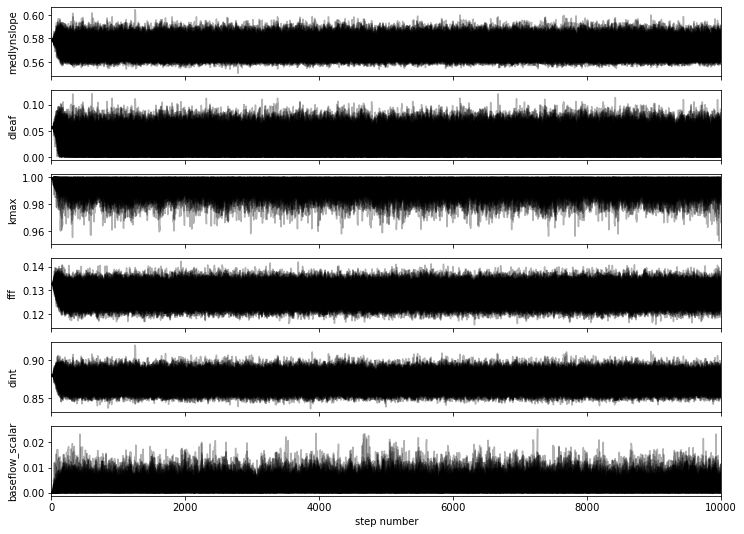

In [49]:
fig, axes = plt.subplots(ndim, figsize=(12, 9), sharex=True)
samples_all = sampler.get_chain()
labels = in_vars
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples_all[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples_all))
    ax.set_ylabel(labels[i])
    
axes[-1].set_xlabel("step number");
#plt.savefig("MCMC_sampler_chain_1e4epochs_ff100.pdf")

Plot log probability

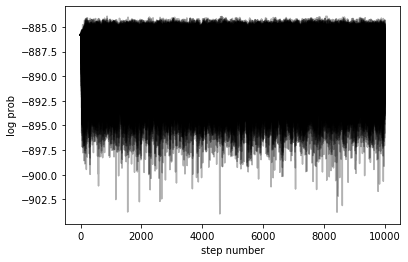

In [38]:
probs_all = sampler.get_log_prob()
plt.plot(probs_all, "k", alpha=0.3) # can't figure out the best way to plot this; too large to exponentiate
plt.xlabel("step number")
plt.ylabel("log prob");

Get estimate of autocorrelation time - helps determine length of chain (number of epochs)

In [39]:
tau = sampler.get_autocorr_time()
print(tau) # do I need a longer chain? emcee will produce generalized estimates/guidance (i.e., run for epochs=50*tau)

[ 94.57226185  94.80665928 109.27790418  92.78011074  92.69669082
 113.5506481 ]


Plot autocorrelation using different estimates - first define some functions

In [40]:
def next_pow_two(n):
    i = 1
    while i < n:
        i = i << 1
    return i

def autocorr_func_1d(x, norm=True):
    x = np.atleast_1d(x)
    if len(x.shape) != 1:
        raise ValueError("invalid dimensions for 1D autocorrelation function")
    n = next_pow_two(len(x))
    # Compute the FFT and then (from that) the auto-correlation function
    f = np.fft.fft(x - np.mean(x), n=2*n)
    acf = np.fft.ifft(f * np.conjugate(f))[:len(x)].real
    acf /= 4*n
    # Optionally normalize
    if norm:
        acf /= acf[0]
    return acf

# automated windowing following Sokal (1989)
def auto_window(taus, c):
    m = np.arange(len(taus)) < c * taus
    if np.any(m):
        return np.argmin(m)
    return len(taus) - 1

# Goodman & Weare (2010)
def autocorr_gw2010(y, c=5.0):
    f = autocorr_func_1d(np.mean(y, axis=0))
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

def autocorr_new(y, c=5.0):
    f = np.zeros(y.shape[1])
    for yy in y:
        f += autocorr_func_1d(yy)
    f /= len(y)
    taus = 2.0*np.cumsum(f)-1.0
    window = auto_window(taus, c)
    return taus[window]

Iterate over all dimensions and plot

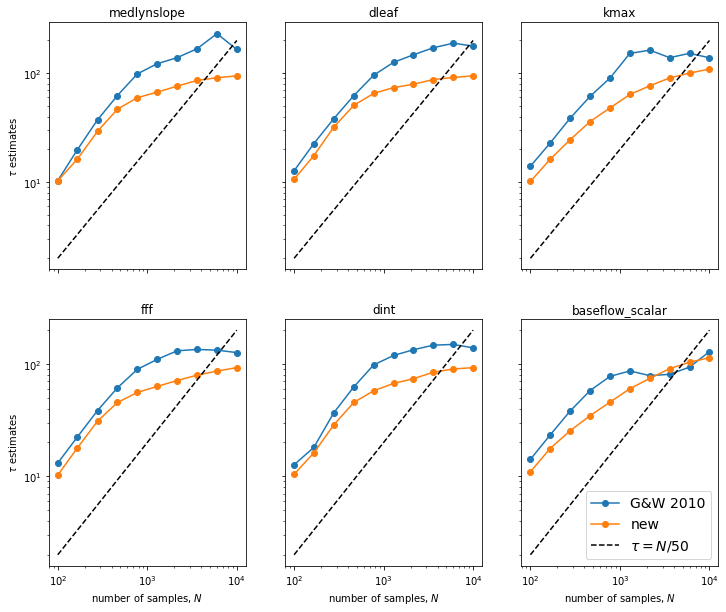

In [41]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex='col', sharey='row', figsize=(12, 10))
labels = in_vars
axes = axes.flatten()
for p in range(ndim):
    chain = samples_all[:,:,p].T
    N = np.exp(np.linspace(np.log(100), np.log(chain.shape[1]), 10)).astype(int)
    gw2010 = np.empty(len(N))
    new = np.empty(len(N))

    for i, n in enumerate(N):
        gw2010[i] = autocorr_gw2010(chain[:, :n])
        new[i] = autocorr_new(chain[:, :n])

    # need to run for a long enough chain to get a meaningful figure
    ax = axes[p]
    ax.loglog(N, gw2010, "o-", label="G&W 2010")
    ax.loglog(N, new, "o-", label="new")
    #ylim = plt.gca().get_ylim()
    ax.plot(N, N / 50.0, "--k", label=r"$\tau = N/50$")
    #ax.set_ylim(ylim)
    ax.set_title(labels[p])
    
axes[3].set_xlabel("number of samples, $N$")
axes[4].set_xlabel("number of samples, $N$")
axes[5].set_xlabel("number of samples, $N$")
axes[0].set_ylabel(r"$\tau$ estimates")
axes[3].set_ylabel(r"$\tau$ estimates")
plt.legend(fontsize=14);
#plt.savefig("MCMC_autocorr_1e4epochs_v7.pdf")

Plot distributions for final position

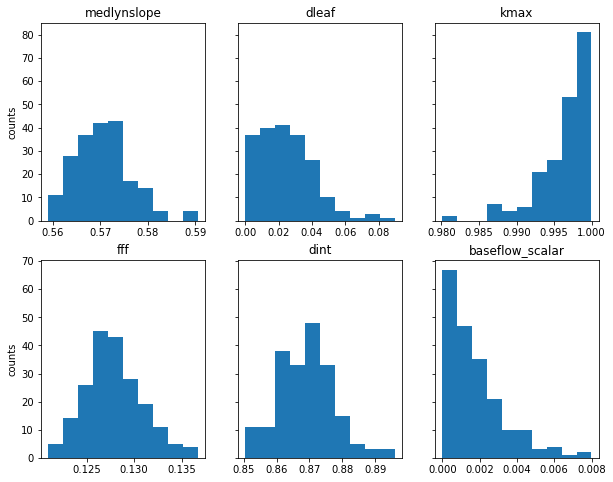

In [42]:
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey='row', figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    #ax.hist(sampler.chain[:,epochs-1,i], color="k", histtype="step")
    ax.hist(sampler.chain[:,epochs-1,i])
    ax.set_title(labels[i])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");

#plt.savefig("MCMC_lastsample_dist_1e4epochs_v7.pdf")

Corner plot

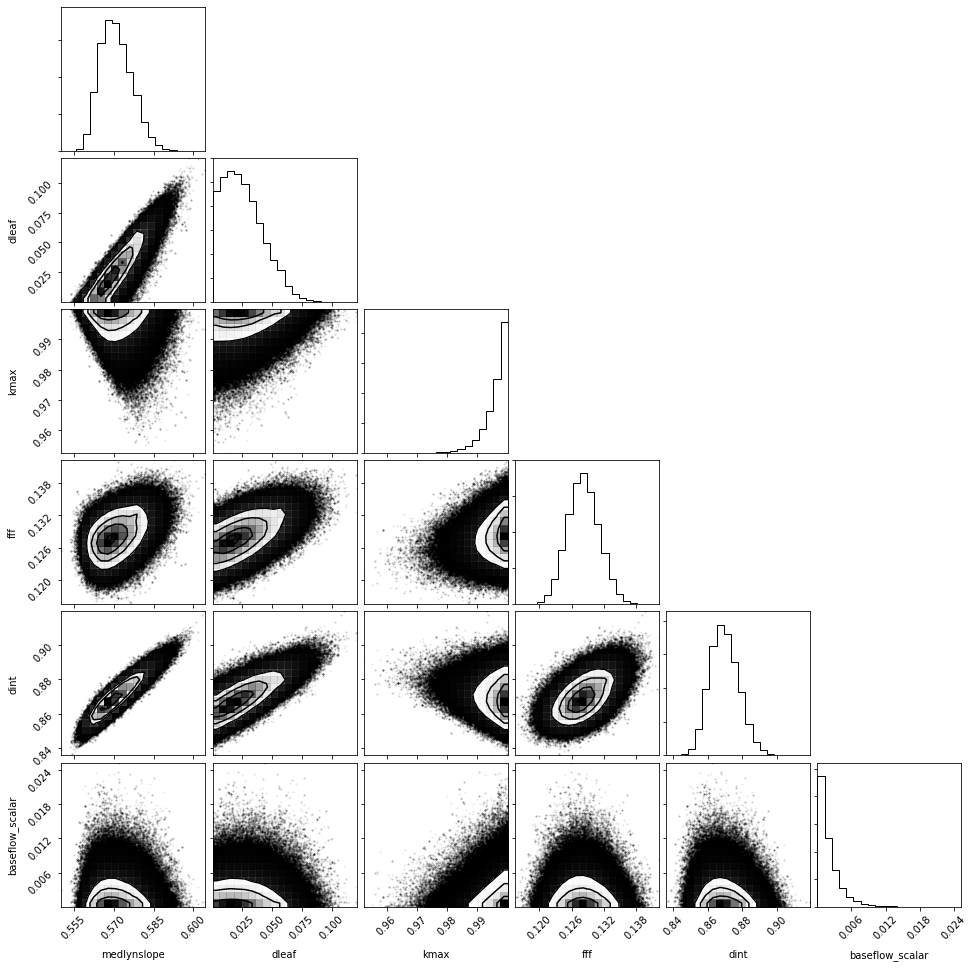

In [48]:
# discard the initial N steps
#flat_samples = sampler.get_chain(discard=1000, flat=True)
# no discard (faster convergence based on initialization)
flat_samples = sampler.get_chain(flat=True)
import corner
fig = corner.corner(flat_samples, labels=in_vars)
#plt.savefig("MCMC_corner_1e4epochs_ff100.pdf")

In [47]:
# final values for all walkers
last_sample = sampler.chain[:,epochs-1,:]
print(last_sample.shape)
print(np.mean(last_sample, axis=0)) # average (over walkers) last position of each parameter
#np.save("MCMC_last_sample_1e4epochs_ff100", last_sample)

(200, 6)
[0.57047197 0.02468493 0.99635425 0.12789821 0.86919273 0.00175674]


In [45]:
# values for all walkers after discard (20000, for 100000 epochs)
#post_discard_samples = sampler.chain[:,20000:,:]
# values for all walkers and last 10 epochs (max ensemble size of nwalkers*10)
#post_discard_samples = sampler.get_chain(discard=epochs-10, flat=True)
#post_discard_samples.shape
#np.save("MCMC_post_discard_samples_1e4epochs_v6", post_discard_samples)

Load and plot previously saved samples

(200, 6)


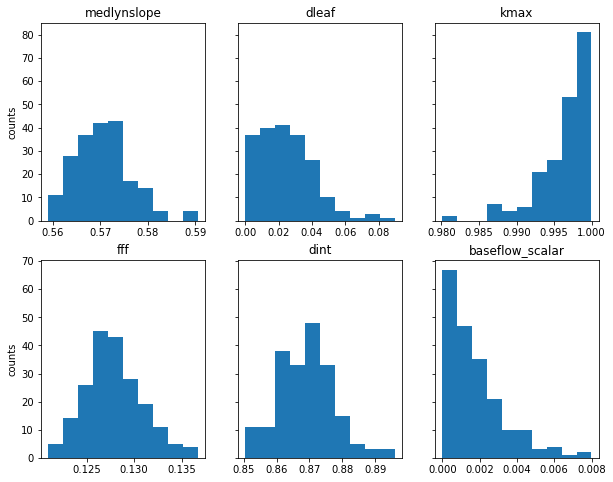

In [54]:
#post_discard_samples_saved = np.load("MCMC_post_discard_samples_1e4epochs_v6.npy")
#print(post_discard_samples_saved.shape)
last_sample_saved = np.load("MCMC_posteriors/MCMC_last_sample_1e4epochs_ff100.npy")
print(last_sample_saved.shape)
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey='row', figsize=(10, 8))
labels = in_vars
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    #ax.hist(post_discard_samples_saved[:,i])
    ax.hist(last_sample_saved[:,i])
    ax.set_title(labels[i])

axes[0].set_ylabel("counts")
axes[3].set_ylabel("counts");